In [ ]:
!pip install rasterio geopandas shapely


In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
from pathlib import Path

In [ ]:
dem_path = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/'
                'srtm-cgiar-nepal-boundary-dem-90m/'
                'srtm_cgiar_nepal_boundary.img')
shp_path = Path('/content/drive/MyDrive/Flood_Thesis/Data/'
                'kathmandu valley border/kathmandu valley border.shp')

In [ ]:
valley = gpd.read_file(shp_path).to_crs(epsg=4326)
with rasterio.open(dem_path) as src:
    dem_clip, transform = mask(src, [valley.unary_union], crop=True)
    dem = dem_clip[0].astype('float32')
    meta = src.meta.copy()

<ipython-input-6-33f83c717d83>:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dem_clip, transform = mask(src, [valley.unary_union], crop=True)


In [ ]:
dx_deg = transform[0]            # ≈0.000833°
dy_deg = -transform[4]           # ≈0.000833°

In [ ]:
# mean latitude of valley for lon-scale
rows, cols = dem.shape
lat_top = transform[5]
lat_center = lat_top - dy_deg * rows/2
m_per_deg_lat = 110574
m_per_deg_lon = 111320 * np.cos(np.deg2rad(lat_center))
dx = dx_deg * m_per_deg_lon      # meters per pixel in X
dy = dy_deg * m_per_deg_lat      # meters per pixel in Y


In [ ]:
# 4️⃣ Compute gradients & slope
dz_dy, dz_dx = np.gradient(dem, dy, dx)
slope = np.degrees(np.arctan(np.hypot(dz_dx, dz_dy)))

In [ ]:
# 5️⃣ Define 0.25° tiles around ERA5 centers
centers_lat = np.array([27.4, 27.65])
centers_lon = np.array([85.15, 85.4])
half = 0.125
lat_edges = np.concatenate((centers_lat-half, [centers_lat[-1]+half]))
lon_edges = np.concatenate((centers_lon-half, [centers_lon[-1]+half]))


In [ ]:
# 6️⃣ Aggregate slope stats per tile
records = []
from rasterio.io import MemoryFile
for i, latc in enumerate(centers_lat):
    for j, lonc in enumerate(centers_lon):
        lat0, lat1 = lat_edges[i], lat_edges[i+1]
        lon0, lon1 = lon_edges[j], lon_edges[j+1]
        poly = box(lon0, lat0, lon1, lat1)
        # write slope into in-memory raster and mask
        with MemoryFile() as mf:
            mmeta = meta.copy()
            mmeta.update({'dtype':'float32','count':1,'transform':transform,'crs':'EPSG:4326'})
            with mf.open(**mmeta) as tmp:
                tmp.write(slope, 1)
                arr_tile, _ = mask(tmp, [poly], crop=True)
        arr = arr_tile[0]
        arr[arr < 0] = np.nan
        records.append({
            'lat_center': latc, 'lon_center': lonc,
            'mean_slope': np.nanmean(arr),
            'max_slope':  np.nanmax(arr),
            'std_slope':  np.nanstd(arr)
        })

In [ ]:
df = pd.DataFrame(records)
print(df)

   lat_center  lon_center  mean_slope  max_slope  std_slope
0       27.40       85.15         0.0        0.0        0.0
1       27.40       85.40         0.0        0.0        0.0
2       27.65       85.15         0.0        0.0        0.0
3       27.65       85.40         0.0        0.0        0.0


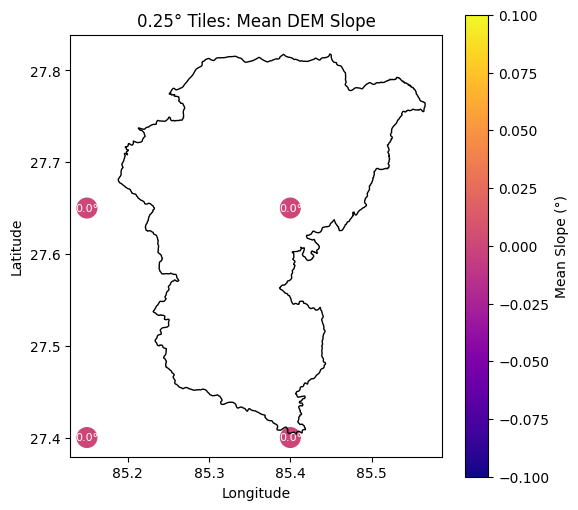

In [ ]:
# 7️⃣ Plot mean slope on the map
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
sc = ax.scatter(df.lon_center, df.lat_center, c=df.mean_slope,
                cmap='plasma', s=200)
for _, r in df.iterrows():
    ax.text(r.lon_center, r.lat_center, f"{r.mean_slope:.1f}°",
            ha='center', va='center', color='white', fontsize=8)
plt.colorbar(sc, ax=ax, label='Mean Slope (°)')
ax.set_title("0.25° Tiles: Mean DEM Slope")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [ ]:
# List every shapefile under your Flood_Thesis folder
from pathlib import Path
root = Path('/content/drive/MyDrive/Flood_Thesis')
for p in root.rglob('*.shp'):
    print(p.relative_to(root))


Data/kathmandu valley border/kathmandu valley border.shp



Slope stats per 0.25° tile:
    lat_center  lon_center  mean_slope  max_slope  std_slope
0       27.40       85.15    6.407813  82.821838  15.094934
1       27.40       85.40   14.796033  87.323318  17.581152
2       27.65       85.15   12.292536  88.066887  18.004236
3       27.65       85.40    9.393925  87.411156  12.438993


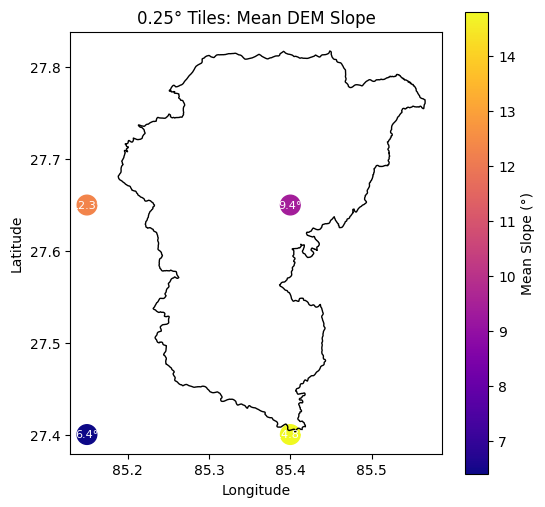

In [ ]:
from pathlib import Path
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Find & load your Kathmandu boundary
data_root = Path('/content/drive/MyDrive/Flood_Thesis/Data')
shp_files = list(data_root.rglob('*.shp'))
shp_path = next(f for f in shp_files if 'kathmandu' in f.name.lower())
valley = gpd.read_file(shp_path).to_crs(epsg=4326)

# 2️⃣ Clip the DEM to the valley
dem_path = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/'
                'srtm-cgiar-nepal-boundary-dem-90m/'
                'srtm_cgiar_nepal_boundary.img')
with rasterio.open(dem_path) as src:
    clip_arr, transform = mask(src, [valley.geometry.union_all()], crop=True)
dem = clip_arr[0].astype('float32')

# 3️⃣ Compute per-pixel slope (90 m resolution approximation)
dx = dy = 90.0  # meters
dz_dy, dz_dx = np.gradient(dem, dy, dx)
slope = np.degrees(np.arctan(np.hypot(dz_dx, dz_dy)))

# 4️⃣ Build lat/lon grids matching the clipped DEM
rows, cols = dem.shape
# Extract Affine parameters
a = transform.a  # pixel width (lon)
b = transform.b  # row rotation (should be 0)
c = transform.c  # lon of upper-left corner
d = transform.d  # col rotation (should be 0)
e = transform.e  # pixel height (lat, negative)
f = transform.f  # lat of upper-left corner
# Compute centers of each pixel
xs = c + (np.arange(cols) + 0.5) * a
ys = f + (np.arange(rows) + 0.5) * e
lon2d, lat2d = np.meshgrid(xs, ys)

# 5️⃣ Define your four 0.25° tiles around centers
centers_lat = [27.4, 27.65]
centers_lon = [85.15, 85.4]
half = 0.125
lat_edges = [cl - half for cl in centers_lat] + [centers_lat[-1] + half]
lon_edges = [cl - half for cl in centers_lon] + [centers_lon[-1] + half]

# 6️⃣ Aggregate slope stats per tile via boolean masks
records = []
for i, latc in enumerate(centers_lat):
    for j, lonc in enumerate(centers_lon):
        lat0, lat1 = lat_edges[i], lat_edges[i+1]
        lon0, lon1 = lon_edges[j], lon_edges[j+1]
        mask_tile = (
            (lat2d >= lat0) & (lat2d < lat1) &
            (lon2d >= lon0) & (lon2d < lon1)
        )
        vals = slope[mask_tile]
        records.append({
            'lat_center': latc,
            'lon_center': lonc,
            'mean_slope': np.nanmean(vals),
            'max_slope':  np.nanmax(vals),
            'std_slope':  np.nanstd(vals)
        })

df = pd.DataFrame(records)
print("\nSlope stats per 0.25° tile:\n", df)

# 7️⃣ Plot mean slope at each tile center
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
sc = ax.scatter(df.lon_center, df.lat_center, c=df.mean_slope,
                cmap='plasma', s=200)
for _, r in df.iterrows():
    ax.text(r.lon_center, r.lat_center, f"{r.mean_slope:.1f}°",
            ha='center', va='center', color='white', fontsize=8)
plt.colorbar(sc, ax=ax, label='Mean Slope (°)')
ax.set_title("0.25° Tiles: Mean DEM Slope")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


Shapefiles found: ['kathmandu valley border/kathmandu valley border.shp']
     lat    lon  dist_to_river_m
0  27.40  85.15     12578.979461
1  27.40  85.40       607.495983
2  27.65  85.15      8073.618970
3  27.65  85.40       113.842145


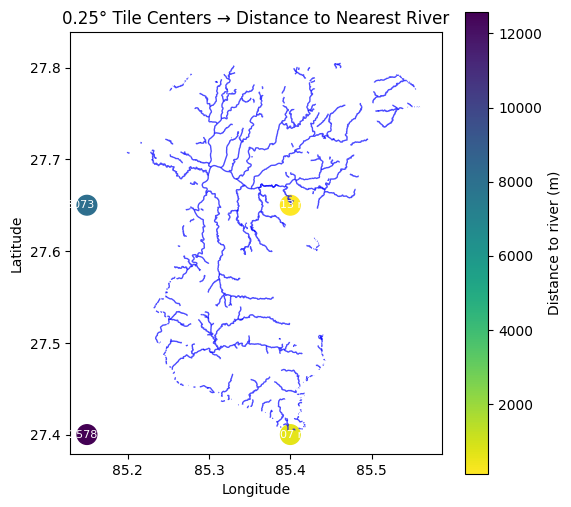

In [ ]:


# 1️⃣ Imports
import requests
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from pathlib import Path
import rasterio
from rasterio.mask import mask

# 2️⃣ Locate your Kathmandu boundary shapefile
data_root = Path('/content/drive/MyDrive/Flood_Thesis/Data')
shp_files = list(data_root.rglob('*.shp'))
print("Shapefiles found:", [str(p.relative_to(data_root)) for p in shp_files])
# pick the one that contains “kathmandu” in its filename
shp_path = next(p for p in shp_files if 'kathmandu' in p.name.lower())
valley   = gpd.read_file(shp_path).to_crs(epsg=4326)

# 3️⃣ Build Overpass query for waterways
west, south, east, north = valley.total_bounds
query = f"""
[out:json][timeout:25];
(
  way["waterway"~"river|stream|canal"]({south},{west},{north},{east});
);
out geom;
"""

# 4️⃣ Fetch & parse
resp = requests.post("https://overpass-api.de/api/interpreter", data={"data": query})
elements = resp.json()['elements']

# 5️⃣ Convert to GeoDataFrame of LineStrings
geoms = []
for el in elements:
    if el['type']=='way' and 'geometry' in el:
        coords = [(pt['lon'], pt['lat']) for pt in el['geometry']]
        geoms.append(LineString(coords))

rivers = gpd.GeoDataFrame(geometry=geoms, crs='EPSG:4326')
# clip exactly to your valley polygon
rivers = gpd.clip(rivers, valley)

# 6️⃣ Define your 0.25° tile‐centers
centers = [
    {'lat':27.40,'lon':85.15},
    {'lat':27.40,'lon':85.40},
    {'lat':27.65,'lon':85.15},
    {'lat':27.65,'lon':85.40},
]
pts = gpd.GeoDataFrame(
    centers,
    geometry=[Point(c['lon'], c['lat']) for c in centers],
    crs='EPSG:4326'
)

# 7️⃣ Compute distance in meters
# project both rivers and points to UTM zone 44N for metric distances
rivers_m = rivers.to_crs(epsg=32644)
pts_m    = pts.to_crs(epsg=32644)
pts['dist_to_river_m'] = pts_m.geometry.apply(lambda p: rivers_m.distance(p).min())

# 8️⃣ Print the results table
print(pts[['lat','lon','dist_to_river_m']])

# 9️⃣ Plot everything
fig, ax = plt.subplots(figsize=(6,6))
valley.boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
rivers.plot(ax=ax, color='blue', linewidth=1, alpha=0.7)
pts.plot(
    ax=ax, column='dist_to_river_m', cmap='viridis_r',
    markersize=200, legend=True,
    legend_kwds={'label':'Distance to river (m)'}
)
for _, row in pts.iterrows():
    ax.text(row.lon, row.lat, f"{int(row.dist_to_river_m)} m",
            ha='center', va='center', color='white', fontsize=8)

ax.set_title("0.25° Tile Centers → Distance to Nearest River")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [ ]:
import geopandas as gpd
import xarray as xr
import pandas as pd
import numpy as np
from shapely.geometry import box
from datetime import datetime, timedelta
from pathlib import Path

# 1️⃣ Paths
flood_folder = Path('/content/drive/MyDrive/Flood_Thesis/Data/Flood_Labels')
# assume you have one GeoTIFF or GeoPackage per date, named like 'flood_YYYYMMDD.tif'
shp_path     = Path('/content/drive/MyDrive/Flood_Thesis/Data/'
                    'kathmandu valley border/kathmandu valley border.shp')

# 2️⃣ Define 0.25° tile polygons
centers_lat = [27.4, 27.65]
centers_lon = [85.15, 85.4]
half = 0.125
tiles = []
for latc in centers_lat:
    for lonc in centers_lon:
        tiles.append({
            'geometry': box(lonc-half, latc-half, lonc+half, latc+half),
            'lat': latc, 'lon': lonc
        })
tiles_gdf = gpd.GeoDataFrame(tiles, crs='EPSG:4326')

# 3️⃣ List all label dates (assuming daily files)
files = sorted(flood_folder.glob('flood_*.tif'))
dates = [datetime.strptime(f.stem.split('_')[1], '%Y%m%d') for f in files]

# 4️⃣ Loop week by week
records = []
for year in [2017, 2018, 2019]:
    # ISO weeks 1–52 (or 53 if present)
    start = datetime(year, 1, 1)
    # align to Monday
    start -= timedelta(days=start.weekday())
    for wk in range(52):
        week_start = start + timedelta(weeks=wk)
        week_end   = week_start + timedelta(days=7)
        # collect all flood files in this week
        week_files = [f for f, d in zip(files, dates) if week_start <= d < week_end]
        if not week_files:
            frac = [0.0]*len(tiles_gdf)
        else:
            # build a union flood mask for the week
            # read first as xarray
            ds0 = xr.open_rasterio(week_files[0]).sel(band=1)
            mask_union = ds0.values>0
            for f in week_files[1:]:
                ds = xr.open_rasterio(f).sel(band=1)
                mask_union |= (ds.values>0)
                ds.close()
            # compute area of each pixel in degrees → approximate equal area
            pixel_area = abs(ds0['transform'][0] * ds0['transform'][4])  # deg²
            ds0.close()
            # for each tile, clip the mask and compute fraction
            frac = []
            for poly in tiles_gdf.geometry:
                # create a mask of the tile on the same grid
                # (you can use rasterio.mask.mask similarly)
                import rasterio
                from rasterio.mask import mask as rio_mask
                with rasterio.open(week_files[0]) as src:
                    out, _ = rio_mask(src, [poly], crop=True)
                masked = out[0] > 0
                # fraction flooded = flooded pixels / total pixels in tile
                frac.append(masked.sum() / float(masked.size))
        # record
        for (latc, lonc), fval in zip(zip(tiles_gdf.lat, tiles_gdf.lon), frac):
            records.append({
                'year': year,
                'week': wk+1,
                'lat_center': latc,
                'lon_center': lonc,
                'frac_flooded': fval
            })

# 5️⃣ Put into DataFrame
flood_df = pd.DataFrame(records)
print(flood_df.head())

# 6️⃣ (Optional) pivot to time‐series per tile
ts = flood_df.pivot(index=['year','week'], columns=['lat_center','lon_center'], values='frac_flooded')
print(ts)

# Now you have your **label** time‐series for each of the four 0.25° tiles.


   year  week  lat_center  lon_center  frac_flooded
0  2017     1       27.40       85.15           0.0
1  2017     1       27.40       85.40           0.0
2  2017     1       27.65       85.15           0.0
3  2017     1       27.65       85.40           0.0
4  2017     2       27.40       85.15           0.0
lat_center 27.40       27.65      
lon_center 85.15 85.40 85.15 85.40
year week                         
2017 1       0.0   0.0   0.0   0.0
     2       0.0   0.0   0.0   0.0
     3       0.0   0.0   0.0   0.0
     4       0.0   0.0   0.0   0.0
     5       0.0   0.0   0.0   0.0
...          ...   ...   ...   ...
2019 48      0.0   0.0   0.0   0.0
     49      0.0   0.0   0.0   0.0
     50      0.0   0.0   0.0   0.0
     51      0.0   0.0   0.0   0.0
     52      0.0   0.0   0.0   0.0

[156 rows x 4 columns]


In [ ]:
# 1) Mount your Drive (Colab)
from google.colab import drive
drive.mount('/content/drive')

# 2) List everything under your Data directory
from pathlib import Path
data_root = Path('/content/drive/MyDrive/Flood_Thesis/Data')
print("Contents of Flood_Thesis/Data/:")
for p in sorted(data_root.iterdir()):
    print("-", p.name)

# 3) Now list the flood labels folder
flood_dir = data_root / 'Flood_labels'
print("\nContents of Flood_labels/:")
if flood_dir.exists():
    for f in sorted(flood_dir.iterdir()):
        print("-", f.name)
else:
    print("→ Folder not found at", flood_dir)

# 4) Inspect one sample file (if found)
import rasterio, numpy as np
sample = flood_dir / 'flood_label_2017.tif'
if sample.exists():
    with rasterio.open(sample) as src:
        print("\nSample metadata for", sample.name)
        print(" CRS:", src.crs)
        print(" Bounds:", src.bounds)
        print(" Shape:", src.height, "×", src.width)
        arr = src.read(1)
        print(" Unique values (first 10):", np.unique(arr)[:10])
        print(" Flood pixels (>0):", np.count_nonzero(arr > 0))
else:
    print("\nSample file not found:", sample)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of Flood_Thesis/Data/:
- ERA5_Data
- Flood_labels
- final_label_Full_Rez.nc
- final_label_fullrez_latlon.nc
- kathmandu valley border
- smallbox
- smallbox_0.1
- static_data

Contents of Flood_labels/:
- flood_label_2017.tif
- flood_label_2018.tif
- flood_label_2019.tif

Sample metadata for flood_label_2017.tif
 CRS: EPSG:4326
 Bounds: BoundingBox(left=85.14995830876326, bottom=27.399963638571585, right=85.60001426610714, top=27.85019925897229)
 Shape: 5012 × 5010
 Unique values (first 10): [0 1]
 Flood pixels (>0): 7148118


    year  lat_center  lon_center  frac_flooded
0   2017       27.40       85.15      0.330611
1   2017       27.40       85.40      0.309793
2   2017       27.65       85.15      0.313394
3   2017       27.65       85.40      0.235569
4   2018       27.40       85.15      0.356431
5   2018       27.40       85.40      0.443757
6   2018       27.65       85.15      0.332969
7   2018       27.65       85.40      0.269292
8   2019       27.40       85.15      0.108057
9   2019       27.40       85.40      0.100730
10  2019       27.65       85.15      0.101703
11  2019       27.65       85.40      0.099836

Annual fraction flooded per tile:
 lat_center     27.40               27.65          
lon_center     85.15     85.40     85.15     85.40
year                                              
2017        0.330611  0.309793  0.313394  0.235569
2018        0.356431  0.443757  0.332969  0.269292
2019        0.108057  0.100730  0.101703  0.099836


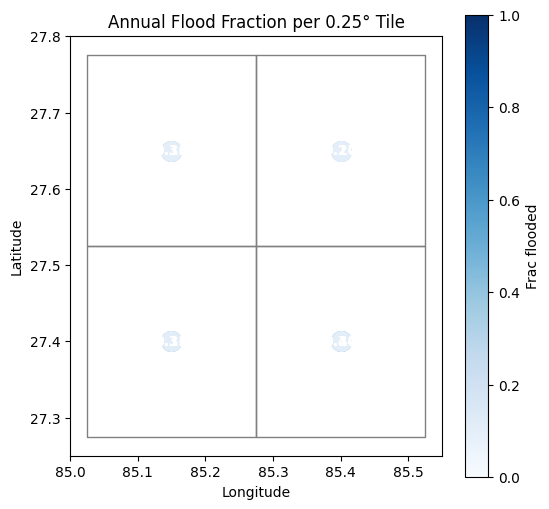

In [ ]:
from pathlib import Path
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box

# 1️⃣ Paths & boundary
data_root = Path('/content/drive/MyDrive/Flood_Thesis/Data')
flood_dir = data_root / 'Flood_labels'
shp_path   = data_root / 'kathmandu valley border' / 'kathmandu valley border.shp'
valley     = gpd.read_file(shp_path).to_crs(epsg=4326)

# 2️⃣ Build your 0.25° tiles
centers_lat = [27.4, 27.65]
centers_lon = [85.15, 85.4]
half = 0.125
tiles = []
for latc in centers_lat:
    for lonc in centers_lon:
        tiles.append({
            'lat': latc,
            'lon': lonc,
            'geometry': box(lonc-half, latc-half, lonc+half, latc+half)
        })
tiles_gdf = gpd.GeoDataFrame(tiles, crs='EPSG:4326')

# 3️⃣ Loop per‐year, and *inside* the with‐block mask each tile
records = []
for year in [2017, 2018, 2019]:
    tif = flood_dir / f"flood_label_{year}.tif"
    with rasterio.open(tif) as src:
        # no need to pre‐clip the whole valley since each tile will clip individually
        for _, tile in tiles_gdf.iterrows():
            # mask the flood raster to the tile footprint
            out_image, _ = mask(
                src,
                [tile.geometry],
                crop=True,
                all_touched=True
            )
            arr = out_image[0]
            total_pixels   = arr.size
            flooded_pixels = np.count_nonzero(arr > 0)
            frac = flooded_pixels / total_pixels if total_pixels else np.nan

            records.append({
                'year': year,
                'lat_center': tile.lat,
                'lon_center': tile.lon,
                'frac_flooded': frac
            })

flood_df = pd.DataFrame(records)
print(flood_df)

# 4️⃣ Pivot or plot
ts = flood_df.pivot(index='year',
                    columns=['lat_center','lon_center'],
                    values='frac_flooded')
print("\nAnnual fraction flooded per tile:\n", ts)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
tiles_gdf.boundary.plot(ax=ax, color='gray', linewidth=1)
for _, r in flood_df.iterrows():
    ax.scatter(r.lon_center, r.lat_center,
               c=r.frac_flooded, cmap='Blues',
               vmin=0, vmax=1, s=200)
    ax.text(r.lon_center, r.lat_center,
            f"{r.frac_flooded:.2f}",
            ha='center', va='center',
            color='white', fontweight='bold')

plt.colorbar(plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(0,1)),
             ax=ax, label='Frac flooded')
ax.set_title("Annual Flood Fraction per 0.25° Tile")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


In [ ]:
from pathlib import Path

# 1️⃣ Point to your static_data folder
static_data_dir = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')

# 2️⃣ Save slope stats (df) as CSV
slope_csv = static_data_dir / 'slope_0.25deg.csv'
df.to_csv(slope_csv, index=False)

# 3️⃣ Save river-distance (pts) as CSV
river_csv = static_data_dir / 'dist_to_river_0.25deg.csv'
pts[['lat','lon','dist_to_river_m']].to_csv(river_csv, index=False)

# 4️⃣ Save river-distance as GeoJSON
river_geojson = static_data_dir / 'dist_to_river_0.25deg.geojson'
pts.to_file(river_geojson, driver='GeoJSON')

print("Files written:")
print(" •", slope_csv)
print(" •", river_csv)
print(" •", river_geojson)


Files written:
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/slope_0.25deg.csv
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/dist_to_river_0.25deg.csv
 • /content/drive/MyDrive/Flood_Thesis/Data/static_data/dist_to_river_0.25deg.geojson
